# ----------------------------------
# Import modules
# ----------------------------------

In [1]:
import os
import requests                      # HTTP client for API calls
import pandas as pd                  # Tabular data handling
from datetime import datetime        # Datetime handling
from typing import Iterable, Optional, Dict, Union
import matplotlib.pyplot as plt
%pip install yfinance
import yfinance as yf
from pprint import pprint as pp

# ----------------------------------
# Import functions
# ----------------------------------

In [2]:
# Load the autoreload extension
%load_ext autoreload

# Reload all modules automatically before executing a cell
%autoreload 2

from src.debug_print import debug_print
from src.fetch_lse_tickers import get_ftse100
from src.exchange_rates import get_share_prices_2 as share_prices, get_share_prices_2_with_fundamentals
from src.roi_hit import get_first_roi_hit
from src.plot_shares_ROI import plot_candles_volatility_volume_roi as ROI
from src.extract_latest_fundamentals import extract_latest_fundamentals
from src.detect_undervalued import detect_undervalued


# ----------------------------------
# Set up variables
# ----------------------------------

In [3]:
base_currency = "GBP"
target_currencies = ["USD", "GBP", "EUR", "JPY"]
cryptos = ["BTC", "ETH"]
shares = ['AAPL', 'RR.L', 'MSFT', 'NVDA', 'LDO.MI','4816.T']

start_date = datetime(2024, 6, 1)
purchase_date = datetime(2025, 6, 1)
end_date = pd.Timestamp.today().normalize()
ROI_target = 0.1


# Get TOP 100 shares from FTSE

In [4]:
ftse100 = get_ftse100()
ftse100["Yahoo_Ticker"] = ftse100["Ticker"] + ".L"
shares_lse = ftse100["Yahoo_Ticker"].to_list()

[DEBUG] File: c:\Users\ingca\OneDrive\Documents\python\finance\src\utils\retry_decorator.py, Function: wrapper, Line: 38
None get_ftse100 succeeded


# --------------------------------
# SHARES' PRICES
# --------------------------------

In [5]:
# df_shares2 = share_prices(
# tickers=shares_lse,
# start=start_date,
# end=end_date,
# base_currency = base_currency,
# vol_window = 20,
# )


# actions_list   = df_shares2.columns.get_level_values("ACTION").unique().to_list()
# print(f"{debug_print()} ACTIONS list:\n{[a.split(".L")[0] for a in actions_list]}")

# currencies_list = df_shares2.columns.get_level_values("CURRENCY").unique()
# metrics   = df_shares2.columns.get_level_values("METRIC").unique()

# SHARES PRICES WITH INFO

In [6]:
df_shares_fund = get_share_prices_2_with_fundamentals(
    tickers=shares_lse,
    start=start_date,
    end=end_date,
    base_currency = base_currency,
    vol_window = 20,
    
)

actions_list   = df_shares_fund.columns.get_level_values("ACTION").unique().to_list()
currencies_list = df_shares_fund.columns.get_level_values("CURRENCY").unique()
metrics   = df_shares_fund.columns.get_level_values("METRIC").unique()

print(f"{debug_print()} ACTIONS list:\n{[a.split(".L")[0] for a in actions_list]}")

[DEBUG] File: c:\Users\ingca\OneDrive\Documents\python\finance\src\utils\retry_decorator.py, Function: wrapper, Line: 38
None get_share_prices_2_with_fundamentals succeeded
[DEBUG] File: C:\Users\ingca\AppData\Local\Temp\ipykernel_2528\2386052970.py, Function: <module>, Line: 14
None ACTIONS list:
['III', 'ADM', 'AAF', 'ALW', 'AAL', 'ANTO', 'AHT', 'ABF', 'AZN', 'AUTO', 'AV', 'BAB', 'BA', 'BARC', 'BTRW', 'BEZ', 'BKG', 'BP', 'BATS', 'BLND', 'BT-A', 'BNZL', 'BRBY', 'CNA', 'CCEP', 'CCH', 'CPG', 'CTEC', 'CRDA', 'DCC', 'DGE', 'DPLM', 'EDV', 'ENT', 'EZJ', 'EXPN', 'FCIT', 'FRES', 'GAW', 'GLEN', 'GSK', 'HLN', 'HLMA', 'HIK', 'HSX', 'HWDN', 'HSBA', 'ICG', 'IHG', 'IMI', 'IMB', 'INF', 'IAG', 'ITRK', 'JD', 'KGF', 'LAND', 'LGEN', 'LLOY', 'LMP', 'LSEG', 'MNG', 'MKS', 'MRO', 'MTLN', 'MNDI', 'NG', 'NWG', 'NXT', 'PSON', 'PSH', 'PSN', 'PHNX', 'PCT', 'PRU', 'RKT', 'REL', 'RTO', 'RMV', 'RIO', 'RR', 'SGE', 'SBRY', 'SDR', 'SMT', 'SGRO', 'SVT', 'SHEL', 'SMIN', 'SN', 'SPX', 'SSE', 'STAN', 'STJ', 'TSCO', 'ULVR',

# EXTRACT UNDERVALUED SHARES

In [7]:
df = extract_latest_fundamentals(
    df=df_shares_fund,
    evaluation_date=purchase_date
)
undervalued_shares = detect_undervalued(df)
print(undervalued_shares)

              Price   EPS  BookValue  Dividend           P/E         P/B  \
ACTION                                                                     
BRBY.L  1035.000000 -0.07   2.483000       NaN -14785.714286  416.834474   
MNG.L    236.699997 -0.02   1.347000      0.20 -11834.999847  175.723828   
CNA.L    158.350006 -0.05   0.670000      0.05  -3167.000122  236.343293   
GLEN.L   283.399994 -0.12   2.360053      0.07  -2361.666616  120.082057   
AAL.L   2162.941406 -1.18  12.047558      0.24  -1833.001192  179.533596   
...             ...   ...        ...       ...           ...         ...   
MKS.L    374.399994  0.01   1.378000      0.04  37439.999390  271.698109   
SMT.L    984.599976   NaN  12.386000       NaN           NaN   79.492974   
FCIT.L  1082.000000   NaN  11.682000       NaN           NaN   92.621127   
ALW.L   1190.000000   NaN  12.819000       NaN           NaN   92.830954   
PCT.L    326.500000   NaN   3.252000       NaN           NaN  100.399754   

        Und

In [8]:
filt = undervalued_shares[undervalued_shares['UndervaluedScore']>0]
undervalued_shares_list = filt['UndervaluedScore'].index.to_list()
print(undervalued_shares_list)
print(actions_list)
ll = set(actions_list).intersection(set(undervalued_shares_list))
print(ll)


['BRBY.L', 'MNG.L', 'CNA.L', 'GLEN.L', 'AAL.L', 'PHNX.L', 'ENT.L', 'VOD.L', 'IHG.L']
['III.L', 'ADM.L', 'AAF.L', 'ALW.L', 'AAL.L', 'ANTO.L', 'AHT.L', 'ABF.L', 'AZN.L', 'AUTO.L', 'AV.L', 'BAB.L', 'BA.L', 'BARC.L', 'BTRW.L', 'BEZ.L', 'BKG.L', 'BP.L', 'BATS.L', 'BLND.L', 'BT-A.L', 'BNZL.L', 'BRBY.L', 'CNA.L', 'CCEP.L', 'CCH.L', 'CPG.L', 'CTEC.L', 'CRDA.L', 'DCC.L', 'DGE.L', 'DPLM.L', 'EDV.L', 'ENT.L', 'EZJ.L', 'EXPN.L', 'FCIT.L', 'FRES.L', 'GAW.L', 'GLEN.L', 'GSK.L', 'HLN.L', 'HLMA.L', 'HIK.L', 'HSX.L', 'HWDN.L', 'HSBA.L', 'ICG.L', 'IHG.L', 'IMI.L', 'IMB.L', 'INF.L', 'IAG.L', 'ITRK.L', 'JD.L', 'KGF.L', 'LAND.L', 'LGEN.L', 'LLOY.L', 'LMP.L', 'LSEG.L', 'MNG.L', 'MKS.L', 'MRO.L', 'MTLN.L', 'MNDI.L', 'NG.L', 'NWG.L', 'NXT.L', 'PSON.L', 'PSH.L', 'PSN.L', 'PHNX.L', 'PCT.L', 'PRU.L', 'RKT.L', 'REL.L', 'RTO.L', 'RMV.L', 'RIO.L', 'RR.L', 'SGE.L', 'SBRY.L', 'SDR.L', 'SMT.L', 'SGRO.L', 'SVT.L', 'SHEL.L', 'SMIN.L', 'SN.L', 'SPX.L', 'SSE.L', 'STAN.L', 'STJ.L', 'TSCO.L', 'ULVR.L', 'UU.L', 'VOD.L', 'WEI

In [9]:
print(df_shares_fund)
metrics   = df_shares_fund.columns.get_level_values("METRIC").unique()
print(metrics)

ACTION                           III.L                                        \
CURRENCY                           GBP                                         
METRIC                             LOW    HIGH   CLOSE      RANGE VOLATILITY   
Date                                                                           
2024-06-03 00:00:00+01:00  2887.000000  2929.0  2926.0  42.000000        NaN   
2024-06-04 00:00:00+01:00  2915.000000  2959.0  2942.0  44.000000        NaN   
2024-06-05 00:00:00+01:00  2912.243896  2969.0  2959.0  56.756104        NaN   
2024-06-06 00:00:00+01:00  2922.000000  2986.0  2952.0  64.000000        NaN   
2024-06-07 00:00:00+01:00  2903.000000  2971.0  2926.0  68.000000        NaN   
...                                ...     ...     ...        ...        ...   
2025-12-23 00:00:00+00:00  3224.000000  3287.0  3235.0  63.000000   0.018916   
2025-12-24 00:00:00+00:00  3206.000000  3250.0  3224.0  44.000000   0.018931   
2025-12-29 00:00:00+00:00  3217.000000  

# ----------- ANALYZE SHARES' PORTFOLIO to get ROI Dates ---------------

In [10]:
portfolio = {}
for action in actions_list:
    try:
        portfolio[action] = get_first_roi_hit(
        df =  df_shares_fund,
        action=action,
        purchase_date=purchase_date,
        roi_target=ROI_target,
    )
    except Exception as e:
        print(f"{type(e).__name__}: {e}")
pp(portfolio, indent=4)

{   'AAF.L': {   'ACTION': 'AAF.L',
                 'DATE TARGET MET': Timestamp('2025-07-24 00:00:00+0100', tz='Europe/London'),
                 'DATE TO ACHIEVE TARGET': Timedelta('53 days 00:00:00'),
                 'EXIT ACTION PRICE': 196.39999389648438,
                 'PURCHASE DATE': Timestamp('2025-06-01 00:00:00+0100', tz='Europe/London'),
                 'PURCHASE PRICE': 177.8000030517578,
                 'SET ROI TARGET': 0.1},
    'AAL.L': {   'ACTION': 'AAL.L',
                 'DATE TARGET MET': Timestamp('2025-09-09 00:00:00+0100', tz='Europe/London'),
                 'DATE TO ACHIEVE TARGET': Timedelta('100 days 00:00:00'),
                 'EXIT ACTION PRICE': 2490.0,
                 'PURCHASE DATE': Timestamp('2025-06-01 00:00:00+0100', tz='Europe/London'),
                 'PURCHASE PRICE': 2220.0,
                 'SET ROI TARGET': 0.1},
    'ABF.L': {   'ACTION': 'ABF.L',
                 'DATE TARGET MET': Timestamp('2025-08-13 00:00:00+0100', tz='Europe

In [11]:
# Clean action name in nested dict
for action, dict_info in portfolio.items():
    if dict_info != None:
        # pp(dict_info, indent=4)
        action_temp = dict_info['ACTION']
        dict_info['ACTION'] = action_temp.split('.L')[0]
# Filter out entries that are None
filtered_portfolio = {k: v for k, v in portfolio.items() if v is not None}
pp(filtered_portfolio, indent=4)
# Sort by 'DATE TO ACHIEVE TARGET'
sorted_data = dict(
    sorted(
        filtered_portfolio.items(),
        key=lambda item: item[1]['DATE TO ACHIEVE TARGET']
    )
)

# Print sorted keys and DATE TO ACHIEVE TARGET
for k, v in sorted_data.items():
    print(k, v['DATE TO ACHIEVE TARGET'])
 

{   'AAF.L': {   'ACTION': 'AAF',
                 'DATE TARGET MET': Timestamp('2025-07-24 00:00:00+0100', tz='Europe/London'),
                 'DATE TO ACHIEVE TARGET': Timedelta('53 days 00:00:00'),
                 'EXIT ACTION PRICE': 196.39999389648438,
                 'PURCHASE DATE': Timestamp('2025-06-01 00:00:00+0100', tz='Europe/London'),
                 'PURCHASE PRICE': 177.8000030517578,
                 'SET ROI TARGET': 0.1},
    'AAL.L': {   'ACTION': 'AAL',
                 'DATE TARGET MET': Timestamp('2025-09-09 00:00:00+0100', tz='Europe/London'),
                 'DATE TO ACHIEVE TARGET': Timedelta('100 days 00:00:00'),
                 'EXIT ACTION PRICE': 2490.0,
                 'PURCHASE DATE': Timestamp('2025-06-01 00:00:00+0100', tz='Europe/London'),
                 'PURCHASE PRICE': 2220.0,
                 'SET ROI TARGET': 0.1},
    'ABF.L': {   'ACTION': 'ABF',
                 'DATE TARGET MET': Timestamp('2025-08-13 00:00:00+0100', tz='Europe/Londo

# ----------- PLOT SHARE - plot_candles_volatility_volume_roi ---------------


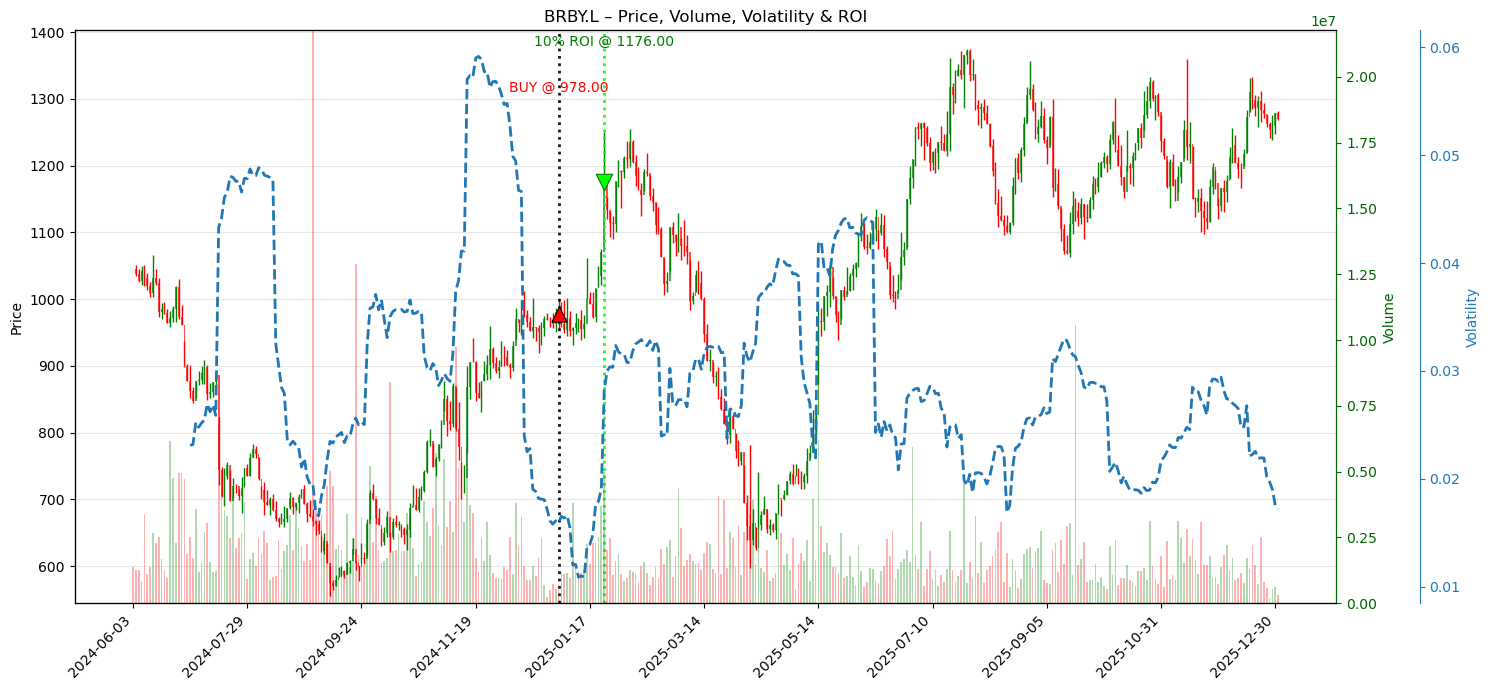

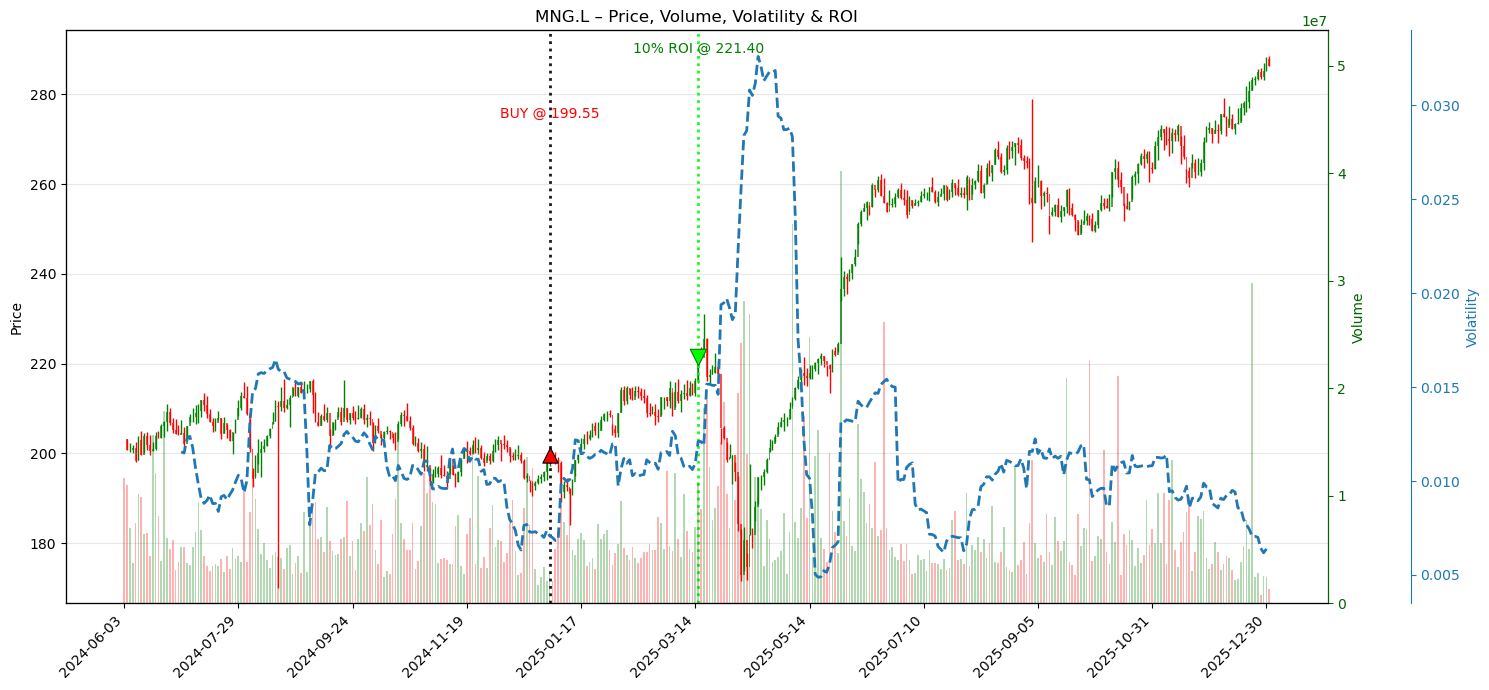

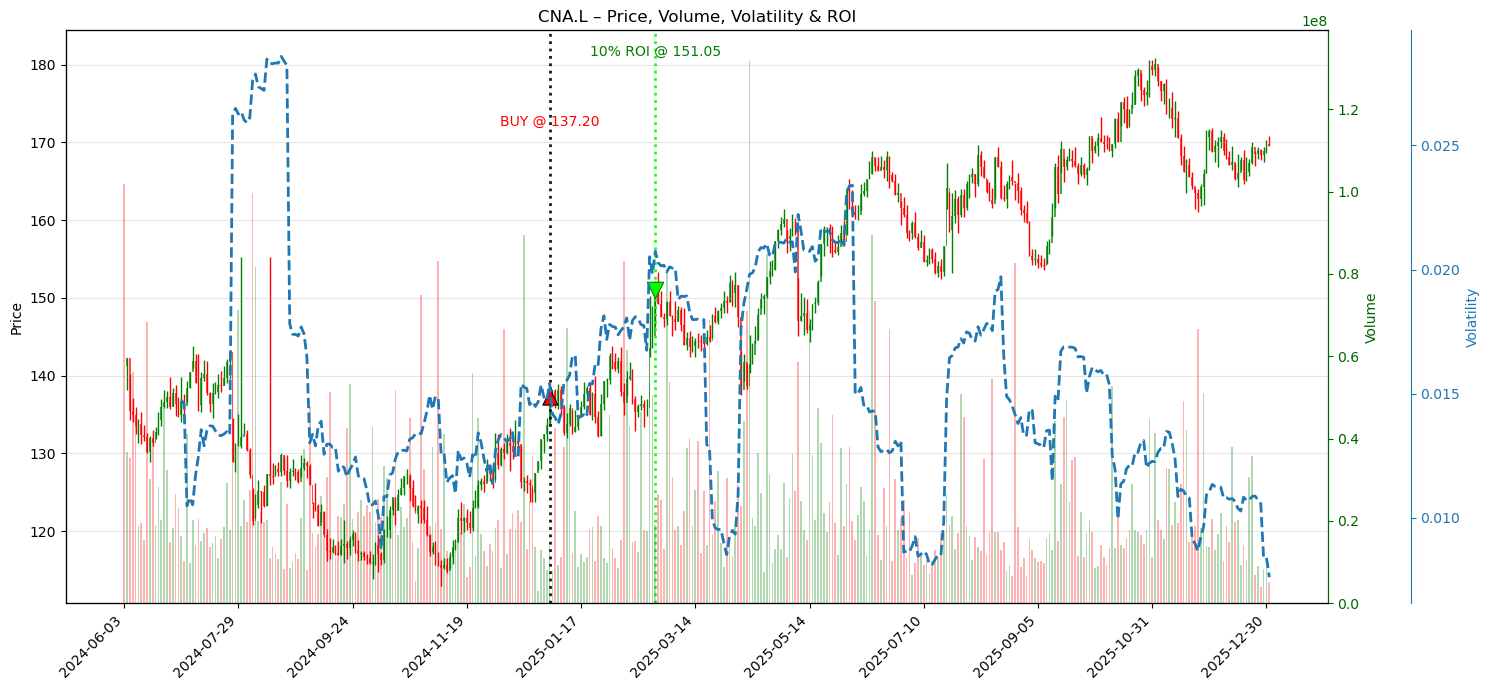

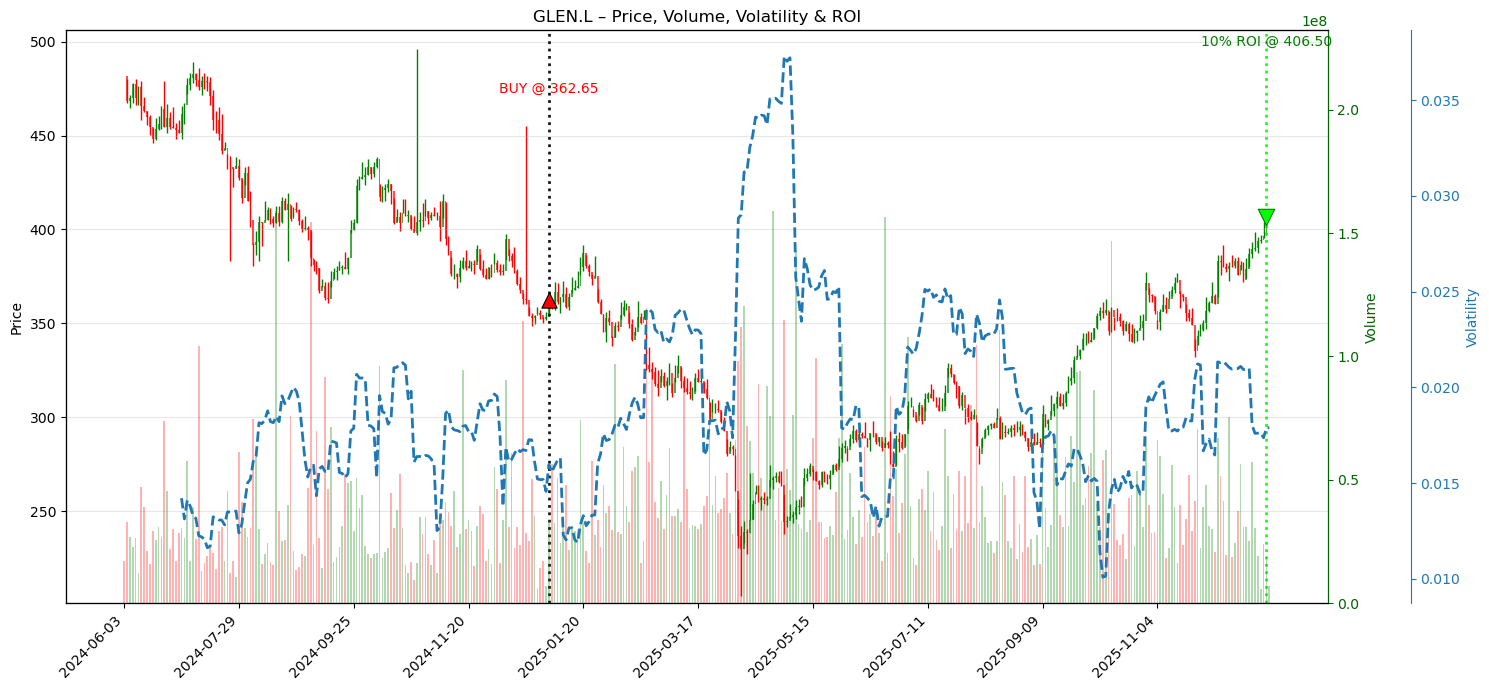

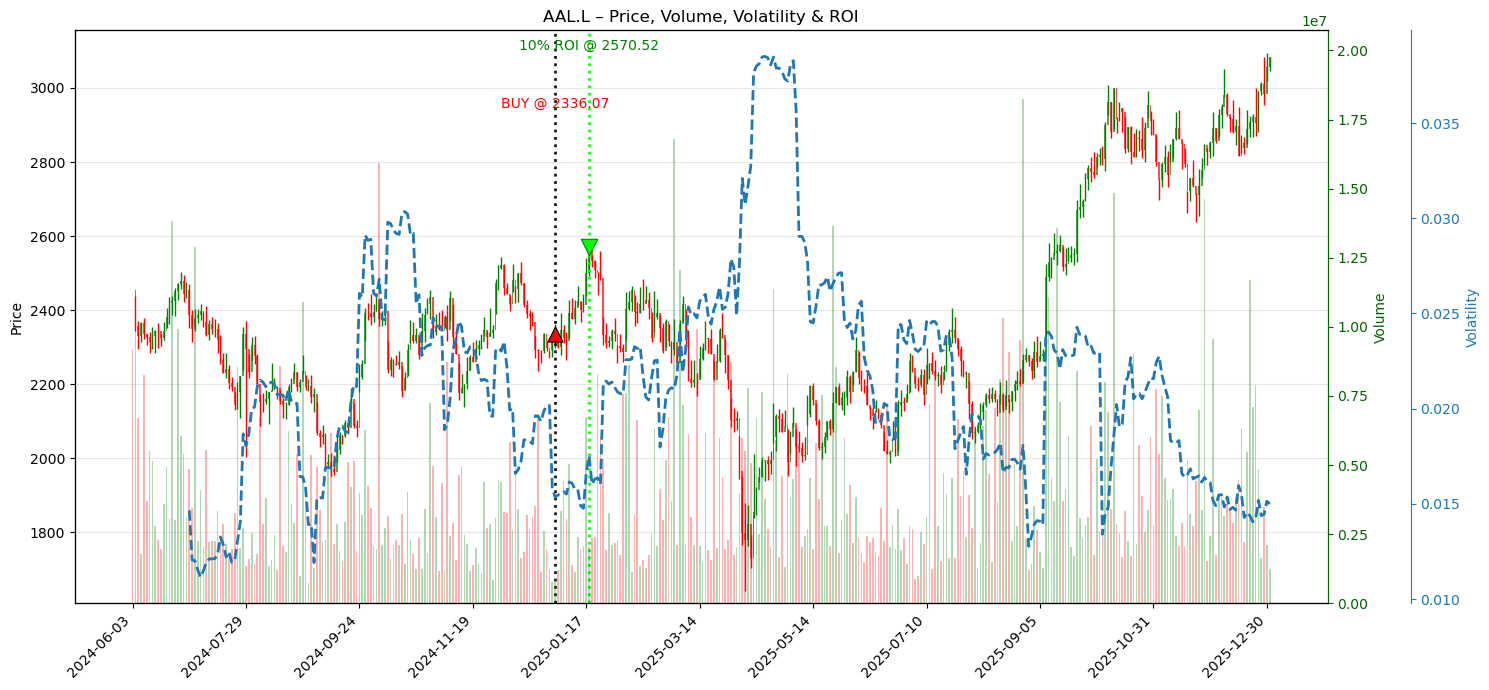

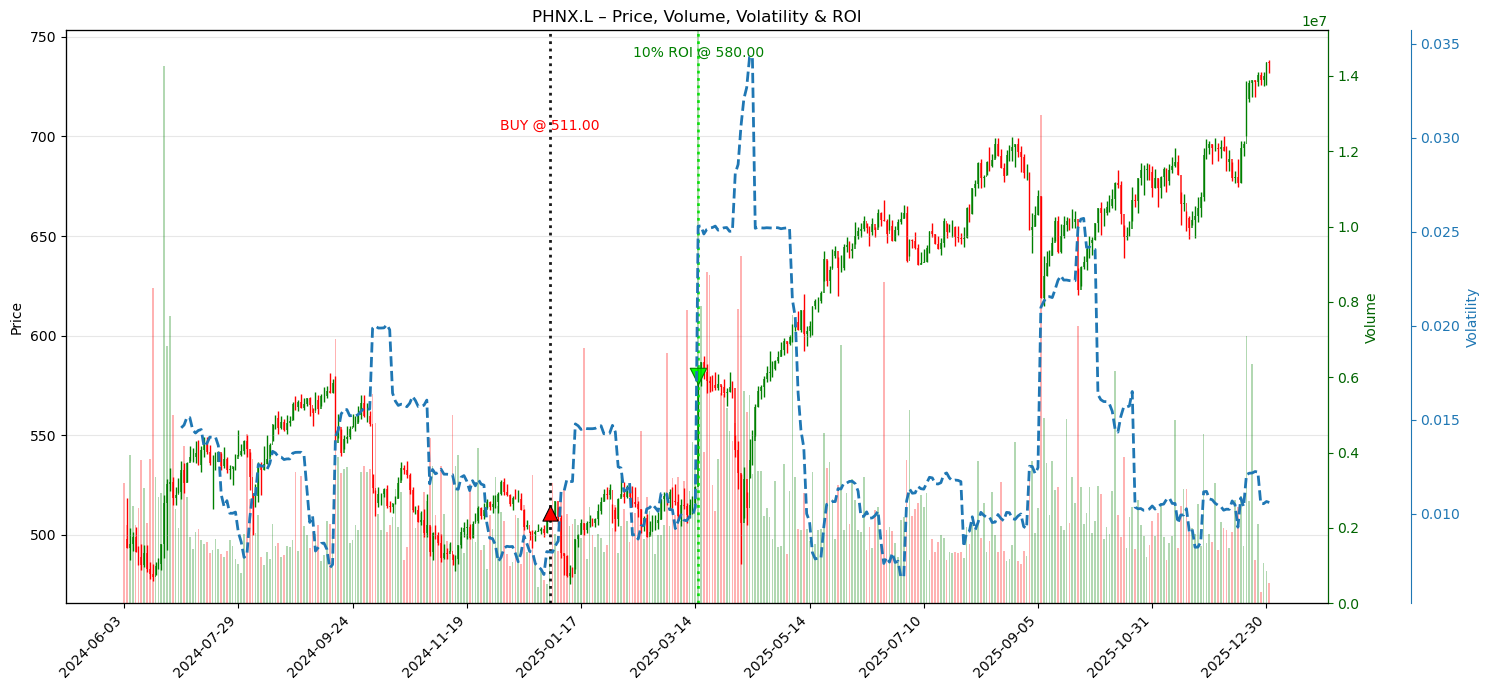

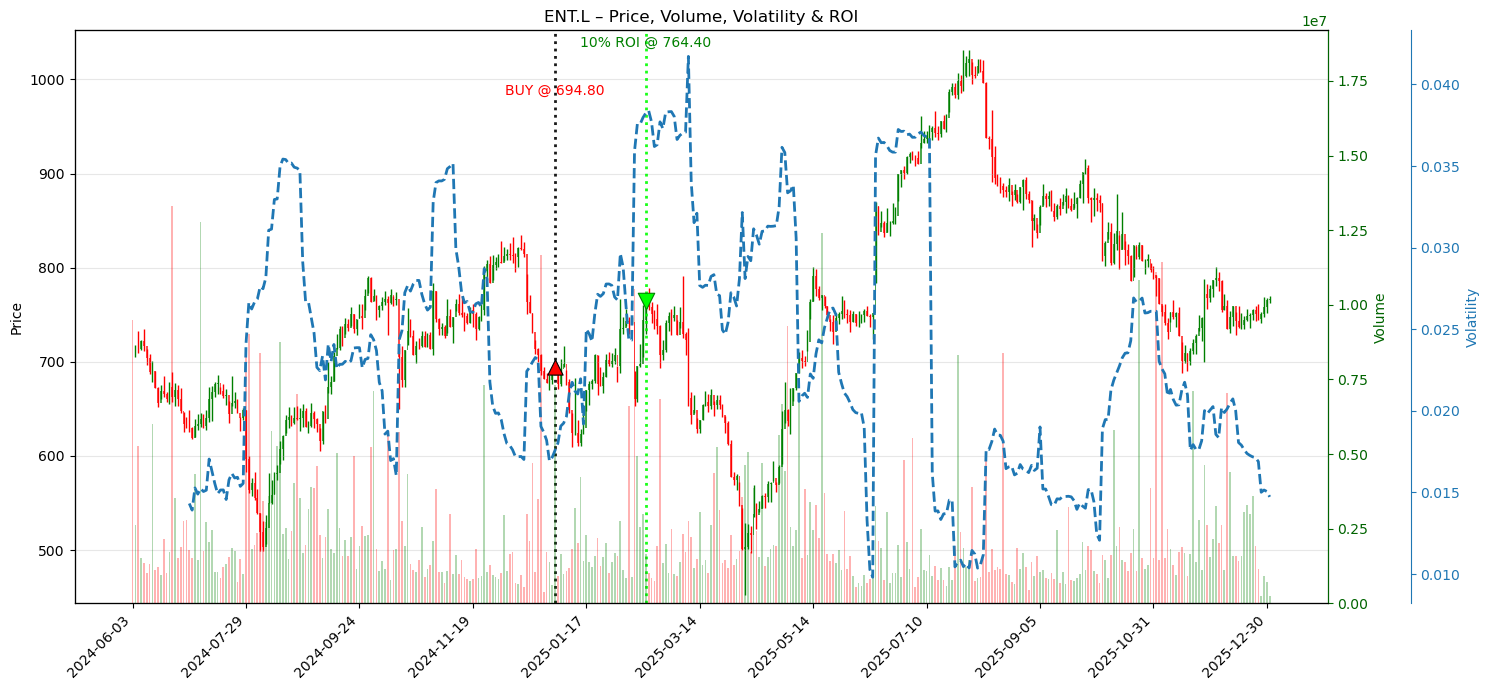

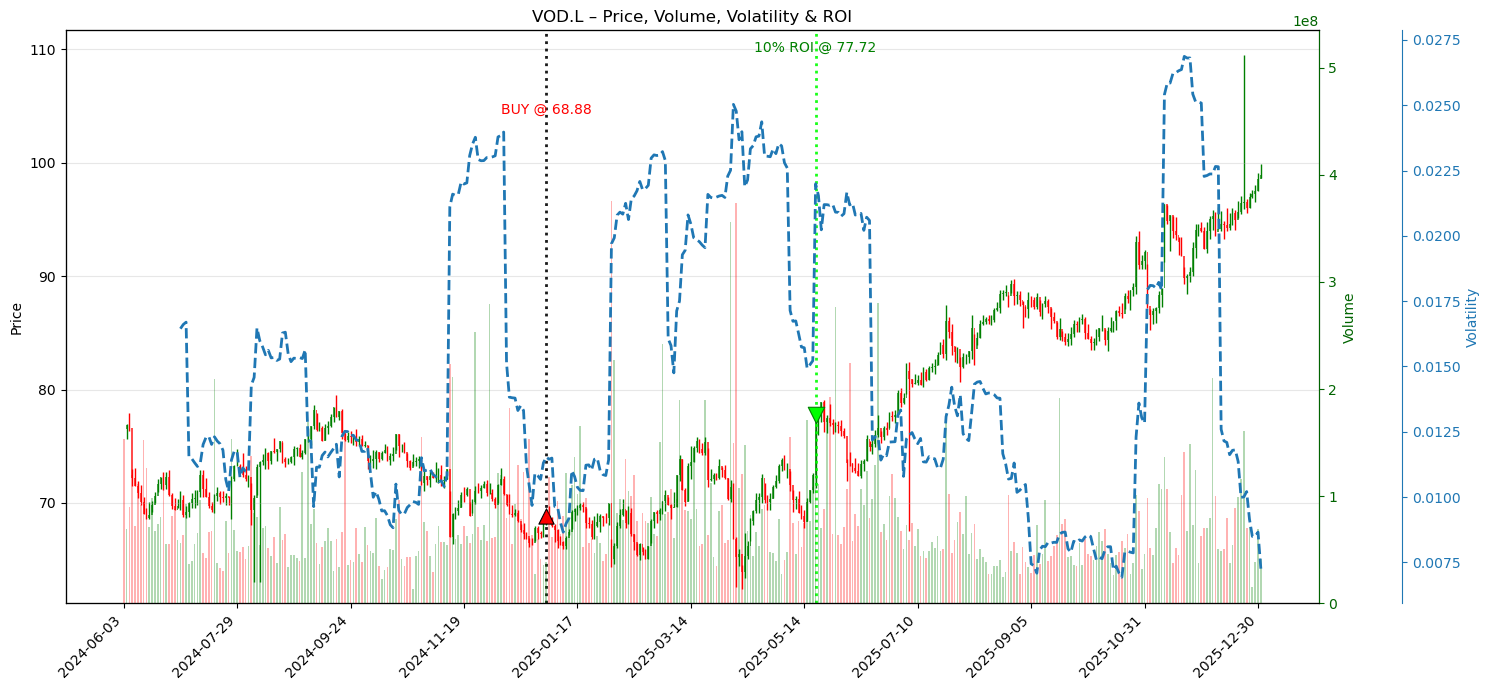

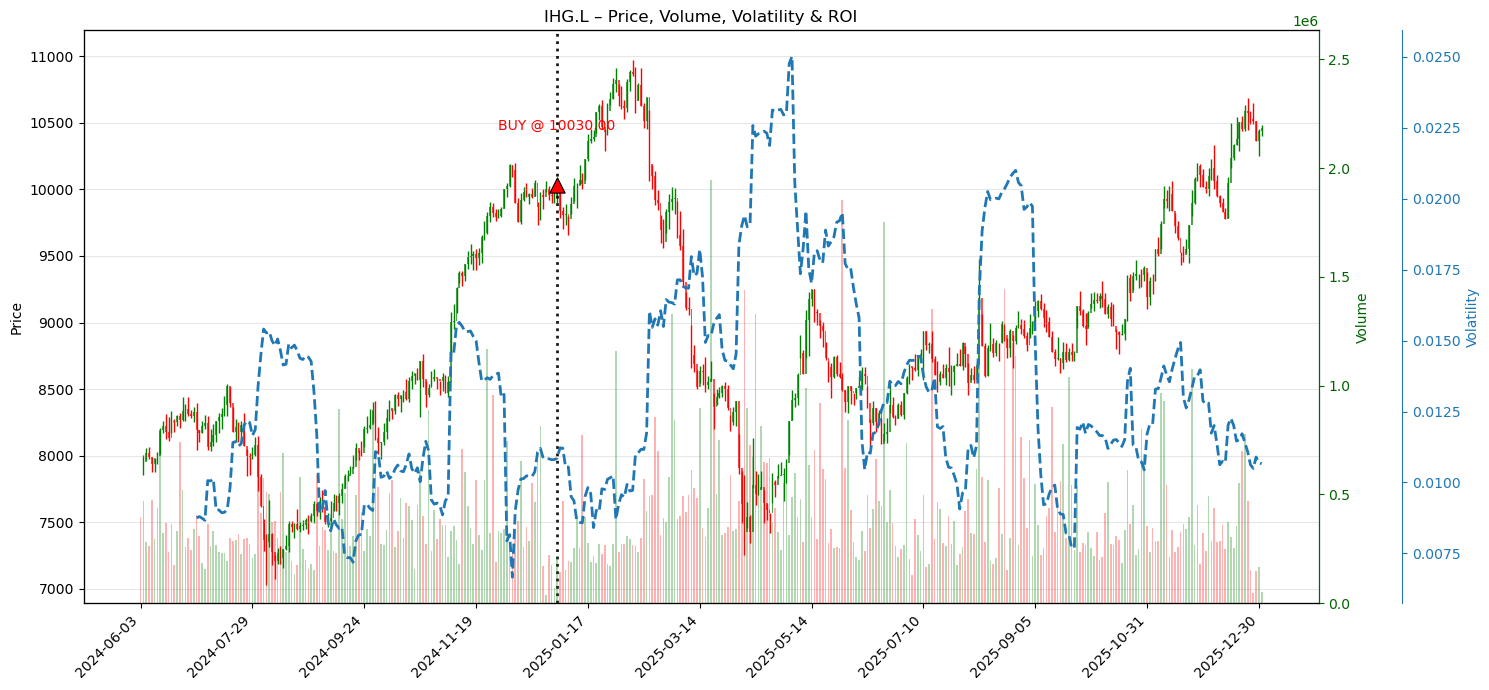

[DEBUG] File: c:\Users\ingca\OneDrive\Documents\python\finance\src\utils\retry_decorator.py, Function: wrapper, Line: 38
None plot_candles_volatility_volume_roi succeeded


In [12]:
ROI(
    df=df_shares_fund,
    actions=undervalued_shares_list,
    # actions=actions_list,
    start=df_shares_fund.index.min(),
    end=df_shares_fund.index.max(),
    purchase_date='2025-01-01',
    roi_target=0.1
)